## Exploratory Analysis
* Classes distribution.
* Classes preview.

In [5]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
import cv2

from sklearn.utils import shuffle

import visualize
reload(visualize)

from sklearn import svm

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer

from sklearn.svm import LinearSVC

from tqdm import tqdm

import pickle

import sys

from sklearn.model_selection import cross_val_score, cross_val_predict


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# keras libraries
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input

from keras.optimizers import SGD

In [2]:
#load the images in a dataframe 
file_names = glob.glob('NWPU-RESISC45/*/*')
file_names_df = [i.split('/')[1:] for i in file_names]
file_names_df = pd.DataFrame(file_names_df, columns=['label','img_name'])
file_names_df['full_img_path'] = file_names

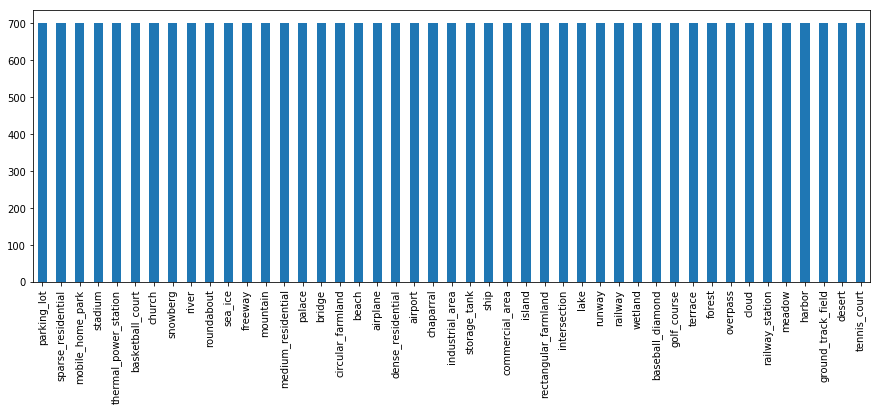

In [3]:
file_names_df['label'].value_counts().plot(kind='bar', figsize=(15,5))

In [3]:
# pick one img from each class to be viewed
sample_images = pd.DataFrame()
for label in file_names_df['label'].unique():
    temp_df = shuffle(file_names_df[file_names_df['label'] == label])
    sample_images = sample_images.append(temp_df[0:1])

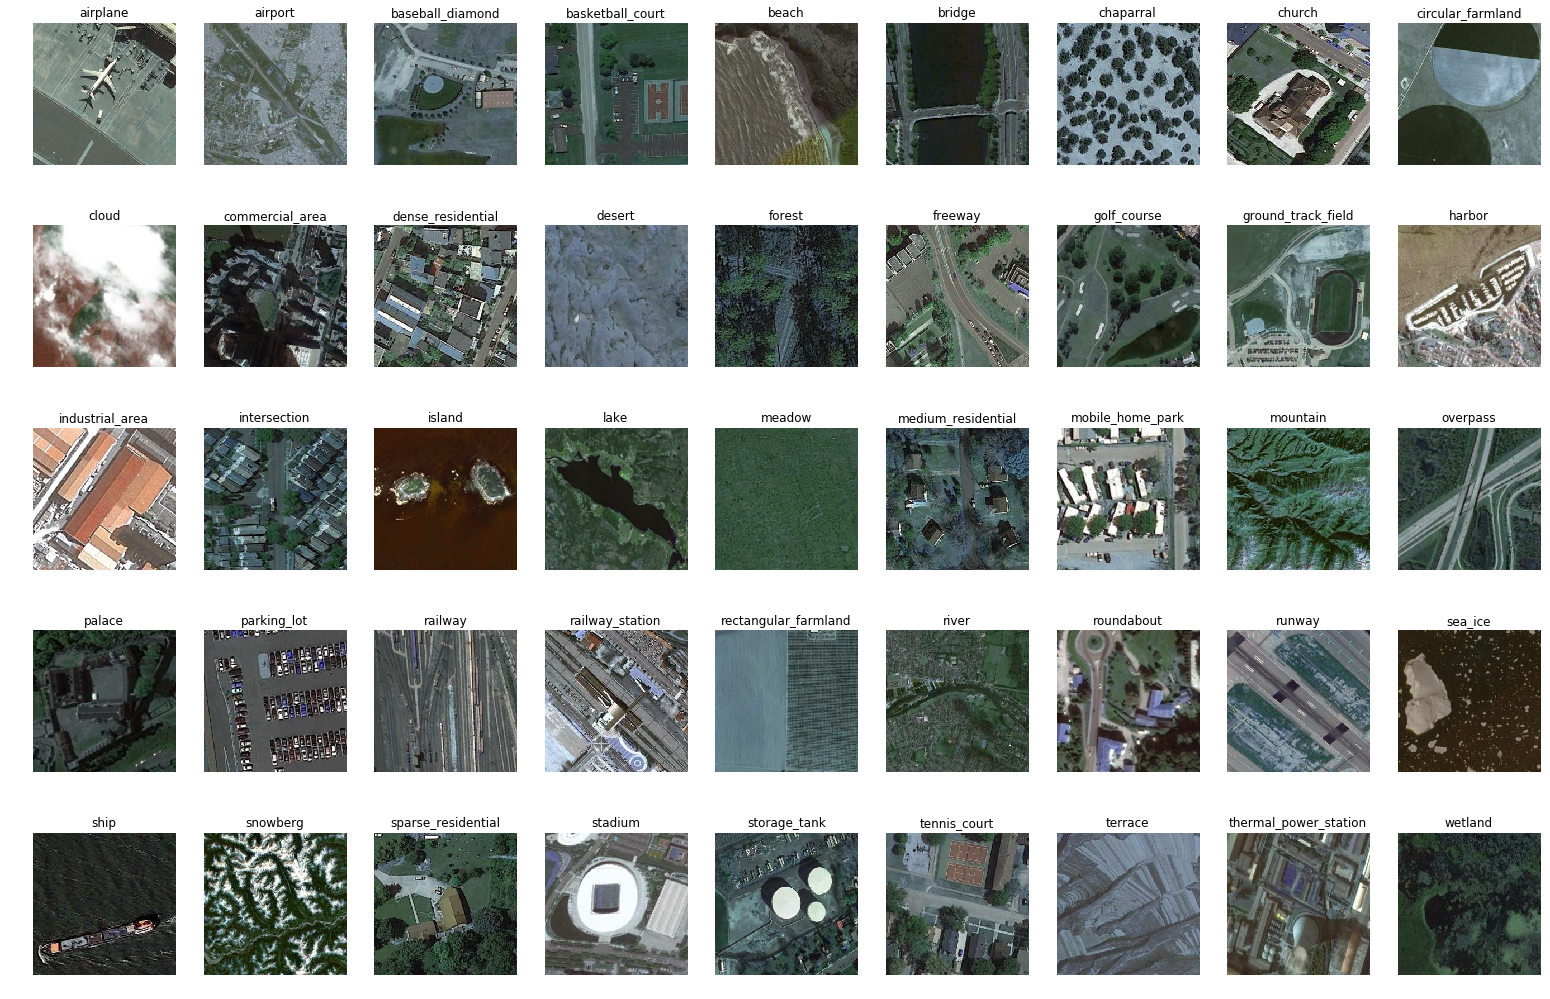

In [6]:
x = sample_images.copy()
x = x.sort_values(['label'])
x['imgs'] = x['full_img_path'].apply(lambda i: cv2.imread(i))
visualize.show_images(x['imgs'].tolist(),cols=5, titles=x['label'].tolist())

## Transfer Learning Using Linear SVM

In [ ]:
# load the selected models
xception = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='max')
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='max')
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='max')

In [ ]:
#load images
images = np.array(file_names_df['full_img_path'].apply(lambda i: cv2.imread(i)).tolist()).astype(np.float32)

In [11]:
#extract features

xception_features = xception.predict(xception_preprocess_input(images))
resnet50_features = resnet50.predict(resnet_preprocess_input(images))
inception_features = inception.predict(inception_preprocess_input(images))

In [5]:
data = {'xception':xception_features, 'resnet50':resnet50_features, 'inception':inception_features}
labels = np.array(file_names_df['label'])

In [6]:
# input:
#   data: dictionary of cnn archetictures as keys and their corresponding tensor data. data is assumed to be preprocessed beforehand.
# labels: class label.
# test percentage in fraction number.
# clf: classifier
# return: 2 dictionary of cnn architectures as keys and a list of accuracies and confusion matrices.
def train_test_5_times(data, labels, test_percentage, clf):
    print 'training 5 folds with train size of '+str((1-test_percentage)*100)+ ' %'
    sys.stdout.flush()
    accuracies = {}
    confusion_matricies = {}
    for key in data.keys():
        print 'processing: ', key
        sys.stdout.flush()
        X = data[key]
        
        accuracies[key] = []
        confusion_matricies[key] = []
     
        

        splitter = ShuffleSplit(n_splits=5, test_size=test_percentage, random_state=0)

        for train_index, test_index in tqdm(splitter.split(X)):
            clf.fit(X[train_index], labels[train_index])
            y_hat = clf.predict(X[test_index])
            
            accuracy = accuracy_score(labels[test_index], y_hat)
            cfnm = confusion_matrix(labels[test_index], y_hat)
            
            accuracies[key].append(accuracy)
            confusion_matricies[key].append(cfnm)
    
            
    return accuracies, confusion_matricies


In [9]:
svm = LinearSVC(random_state=0)
print svm

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


In [10]:
#train size is 10 %
accuracies_1, confusion_matricies_1 = train_test_5_times(data, labels, .9, svm)

training 5 folds with train size of 10.0 %
processing:  inception


5it [43:46, 525.28s/it]

processing:  xception



5it [01:18, 15.75s/it]

processing:  resnet50



5it [05:46, 69.28s/it] 


In [13]:
#train size is 20 %
accuracies_2, confusion_matricies_2 = train_test_5_times(data, labels, .8, svm)

training 5 folds with train size of 20.0 %
processing:  inception


5it [1:38:39, 1183.83s/it]

processing:  xception



5it [02:30, 30.04s/it]

processing:  resnet50



5it [11:10, 134.20s/it]


In [18]:
print 'accuracies of train size of 10 %'
for key in accuracies_1.keys():
    accuracy = np.mean(accuracies_1[key])
    print 'accuracy for '+key+ ' features is '+str(accuracy)+' +/- '+str(np.std(accuracies_1[key]))
    print
    print accuracies_1[key]

    print
    print

accuracies of train size of 10 %
accuracy for inception features is 0.0830899470899 +/- 0.0771747178827

[0.04797178130511464, 0.043703703703703703, 0.056190476190476193, 0.23657848324514991, 0.031005291005291005]


accuracy for xception features is 0.715329805996 +/- 0.00142000611195

[0.71770723104056433, 0.7149559082892416, 0.71527336860670199, 0.71326278659611997, 0.71544973544973545]


accuracy for resnet50 features is 0.323619047619 +/- 0.041981050398

[0.26000000000000001, 0.29520282186948854, 0.33954144620811288, 0.3817636684303351, 0.34158730158730161]




In [19]:
print 'accuracies of train size of 20 %'
for key in accuracies_2.keys():
    accuracy = np.mean(accuracies_2[key])
    print 'accuracy for '+key+ ' features is '+str(accuracy)+' +/- '+str(np.std(accuracies_2[key]))
    print

accuracies of train size of 20 %
accuracy for inception features is 0.107658730159 +/- 0.081595129635

accuracy for xception features is 0.746666666667 +/- 0.00173880176986

accuracy for resnet50 features is 0.300531746032 +/- 0.0289550154573



# Confusion Matrices Visualization

In [4]:
classes = file_names_df['label'].unique().tolist()
classes = sorted(classes)

Normalized confusion matrix


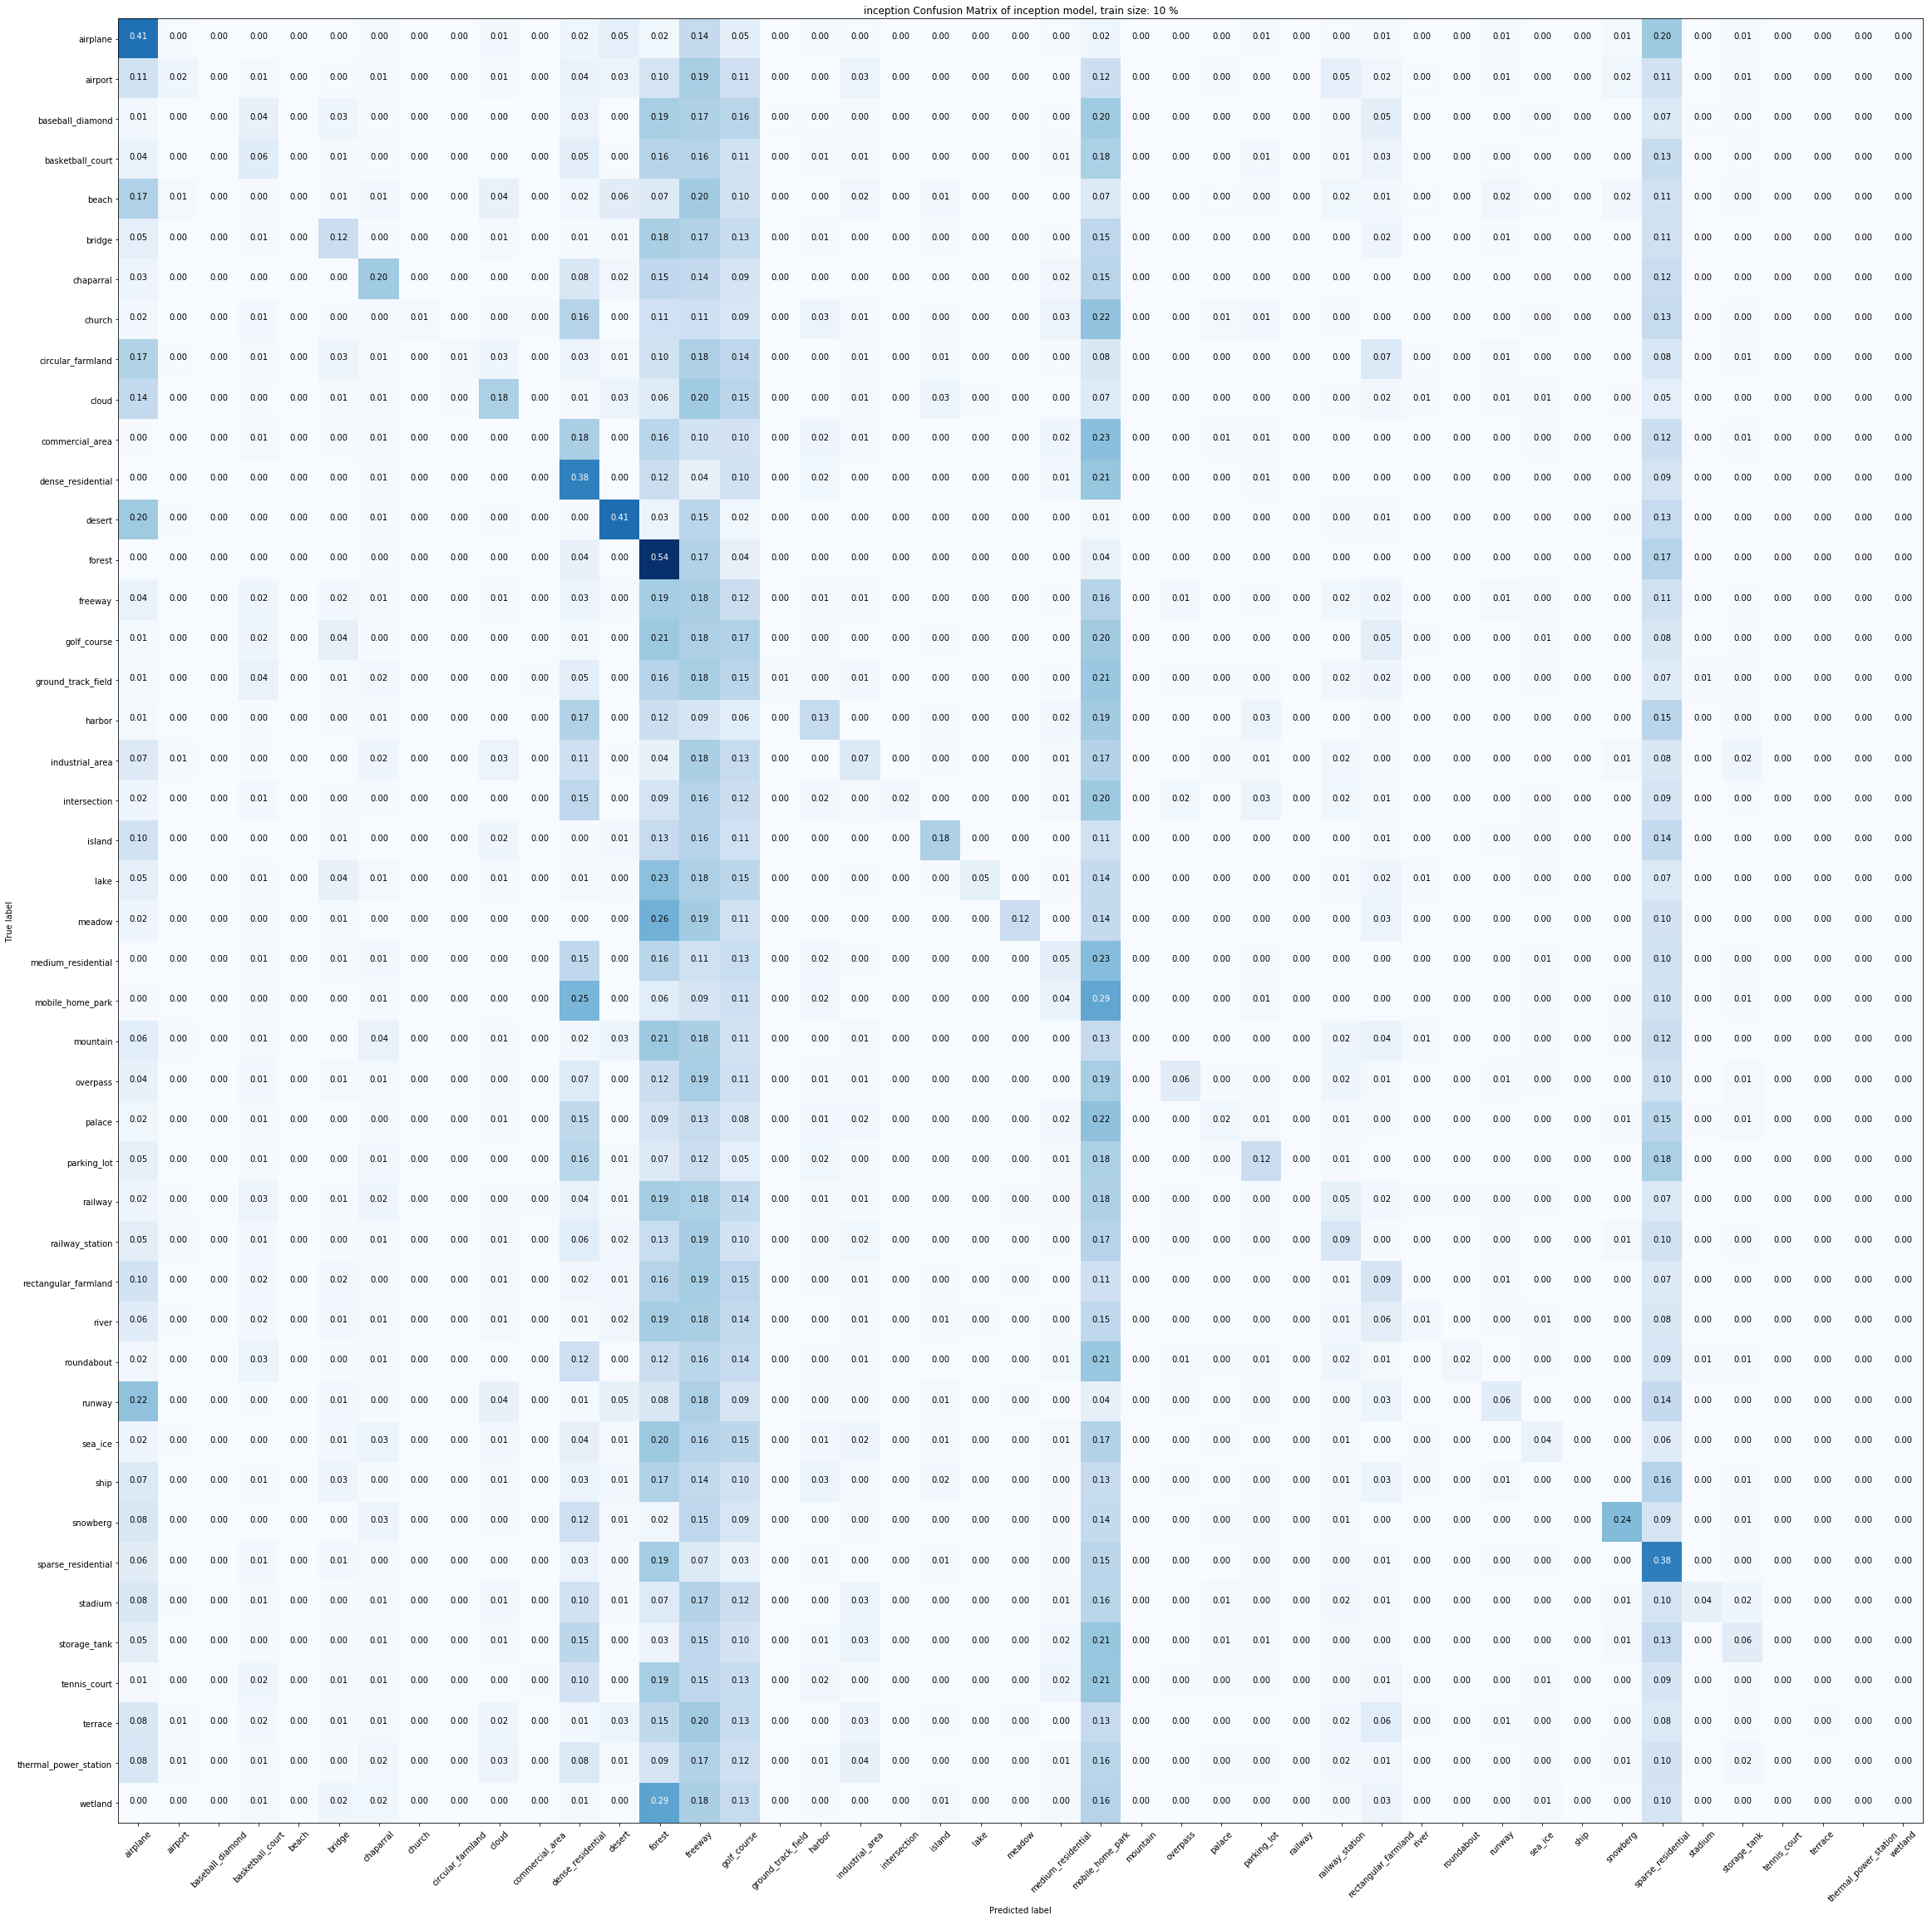

Normalized confusion matrix


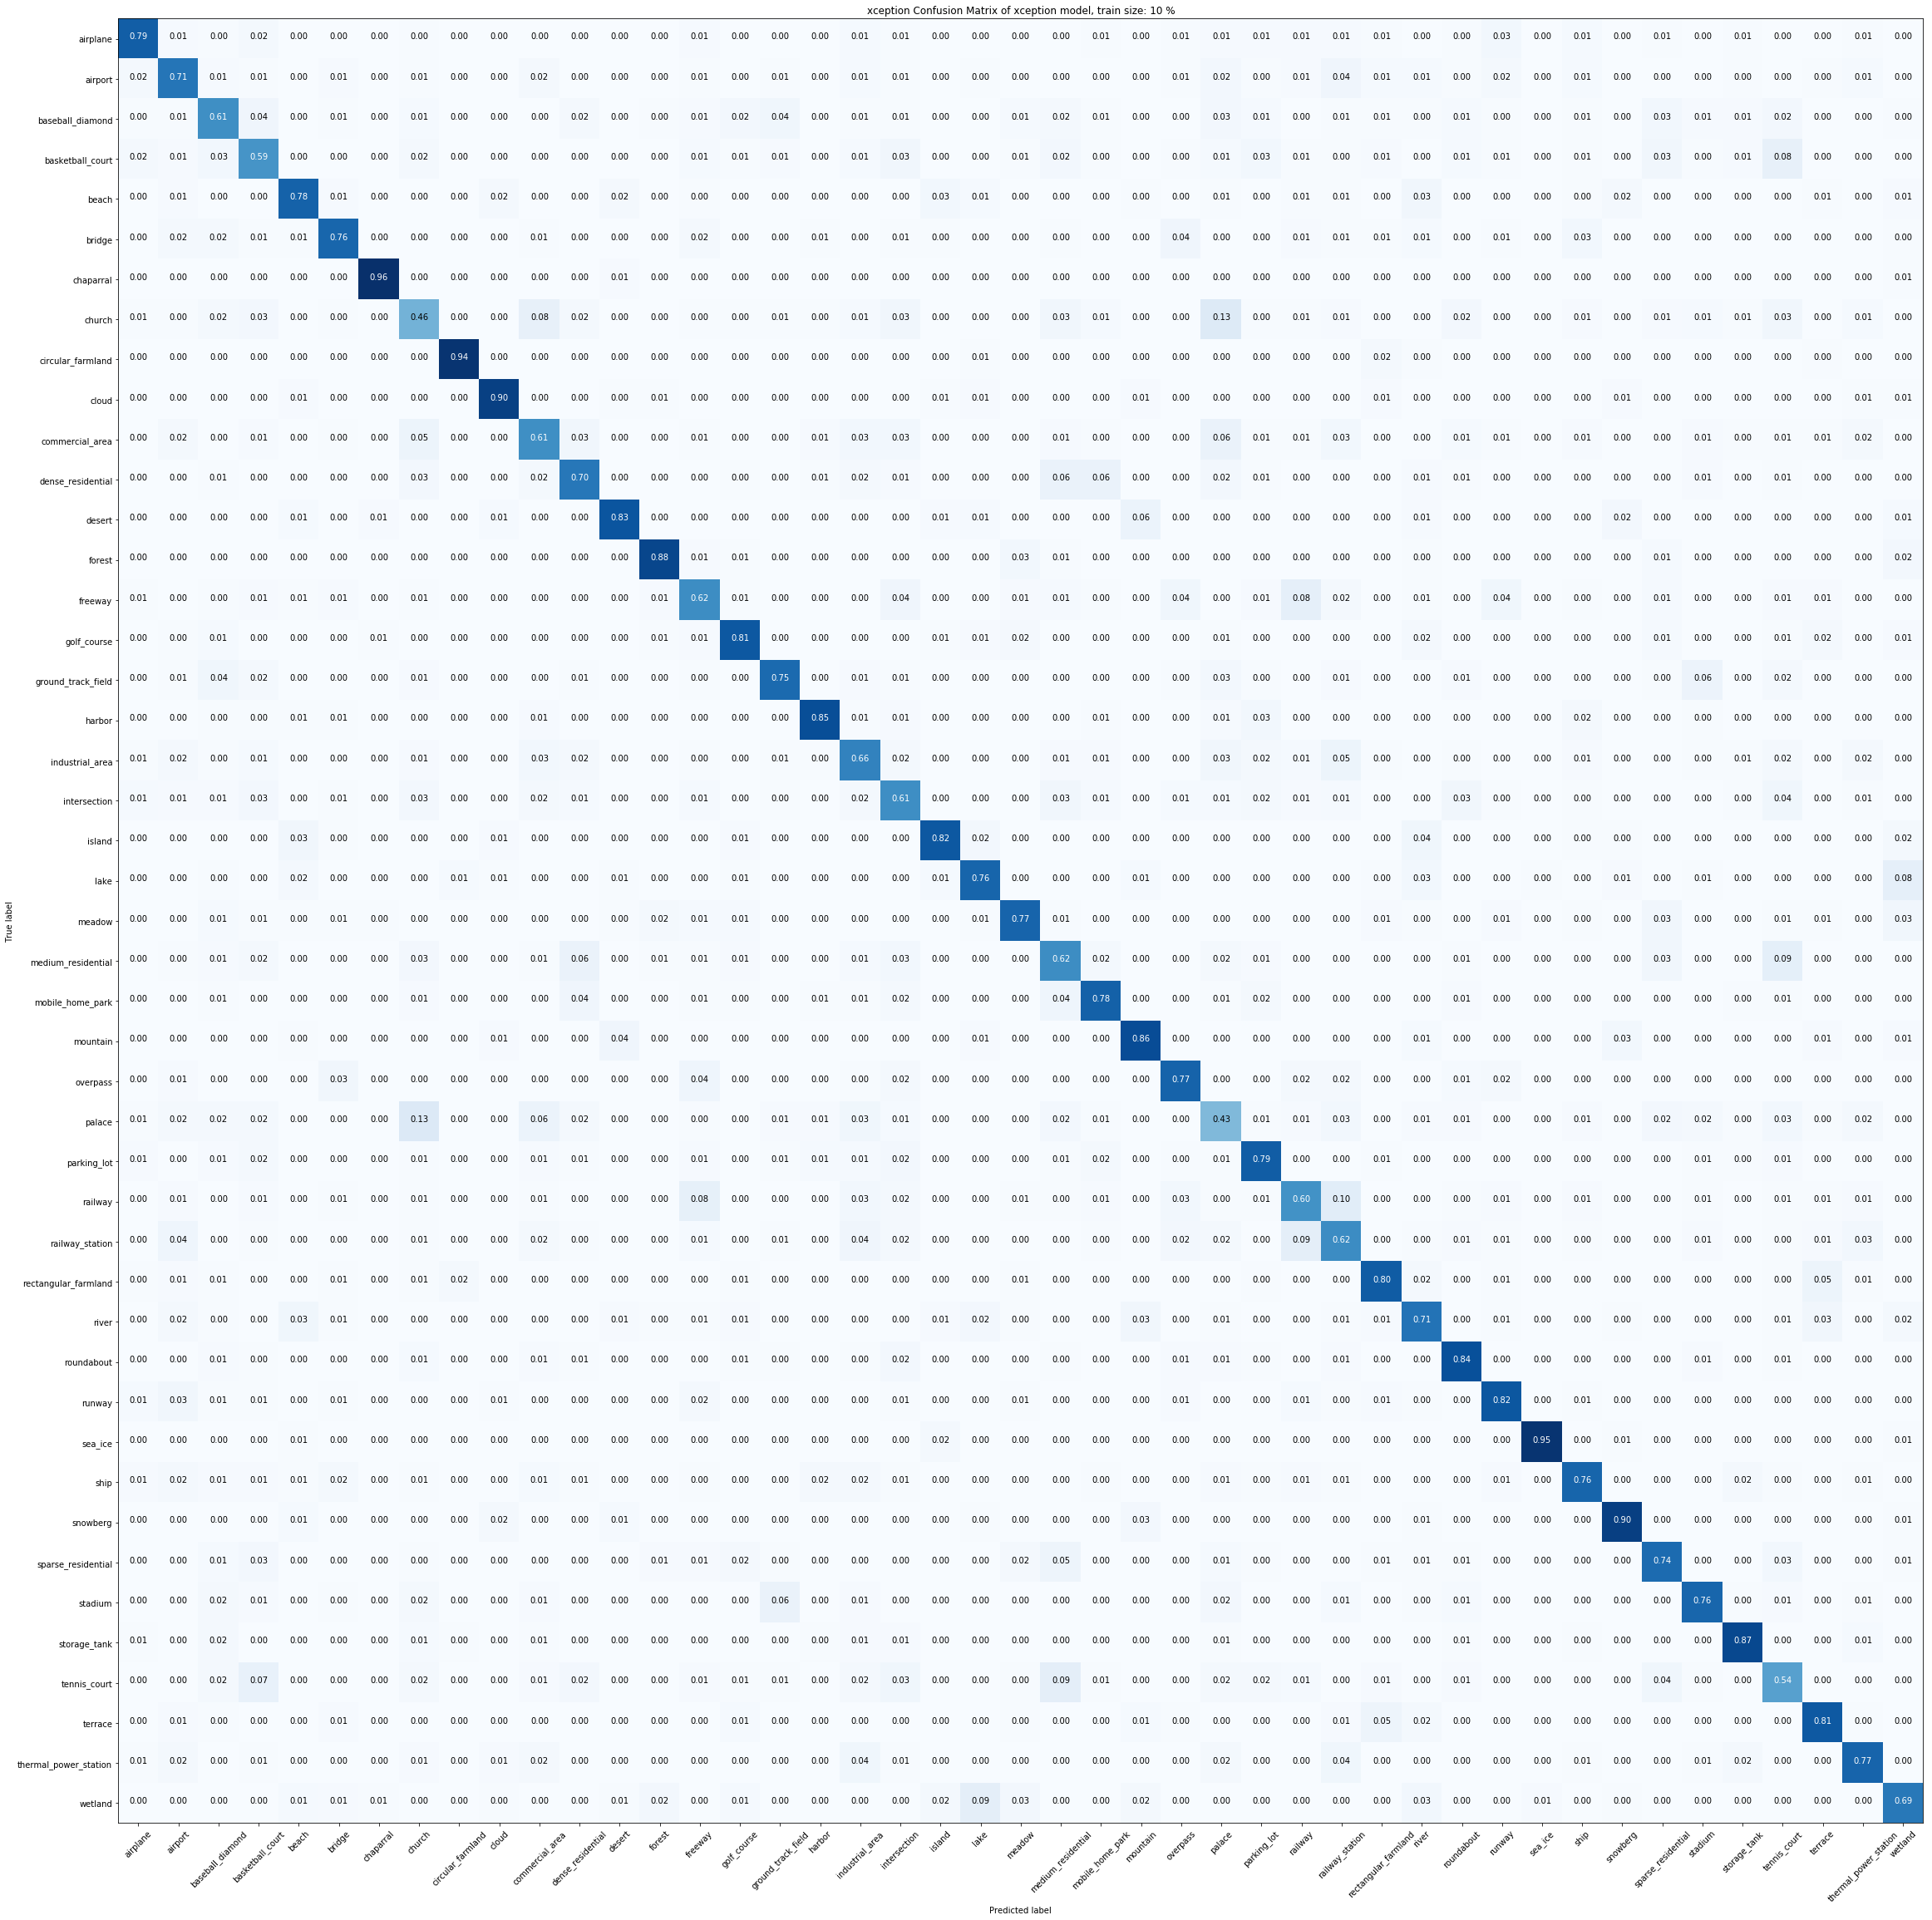

Normalized confusion matrix


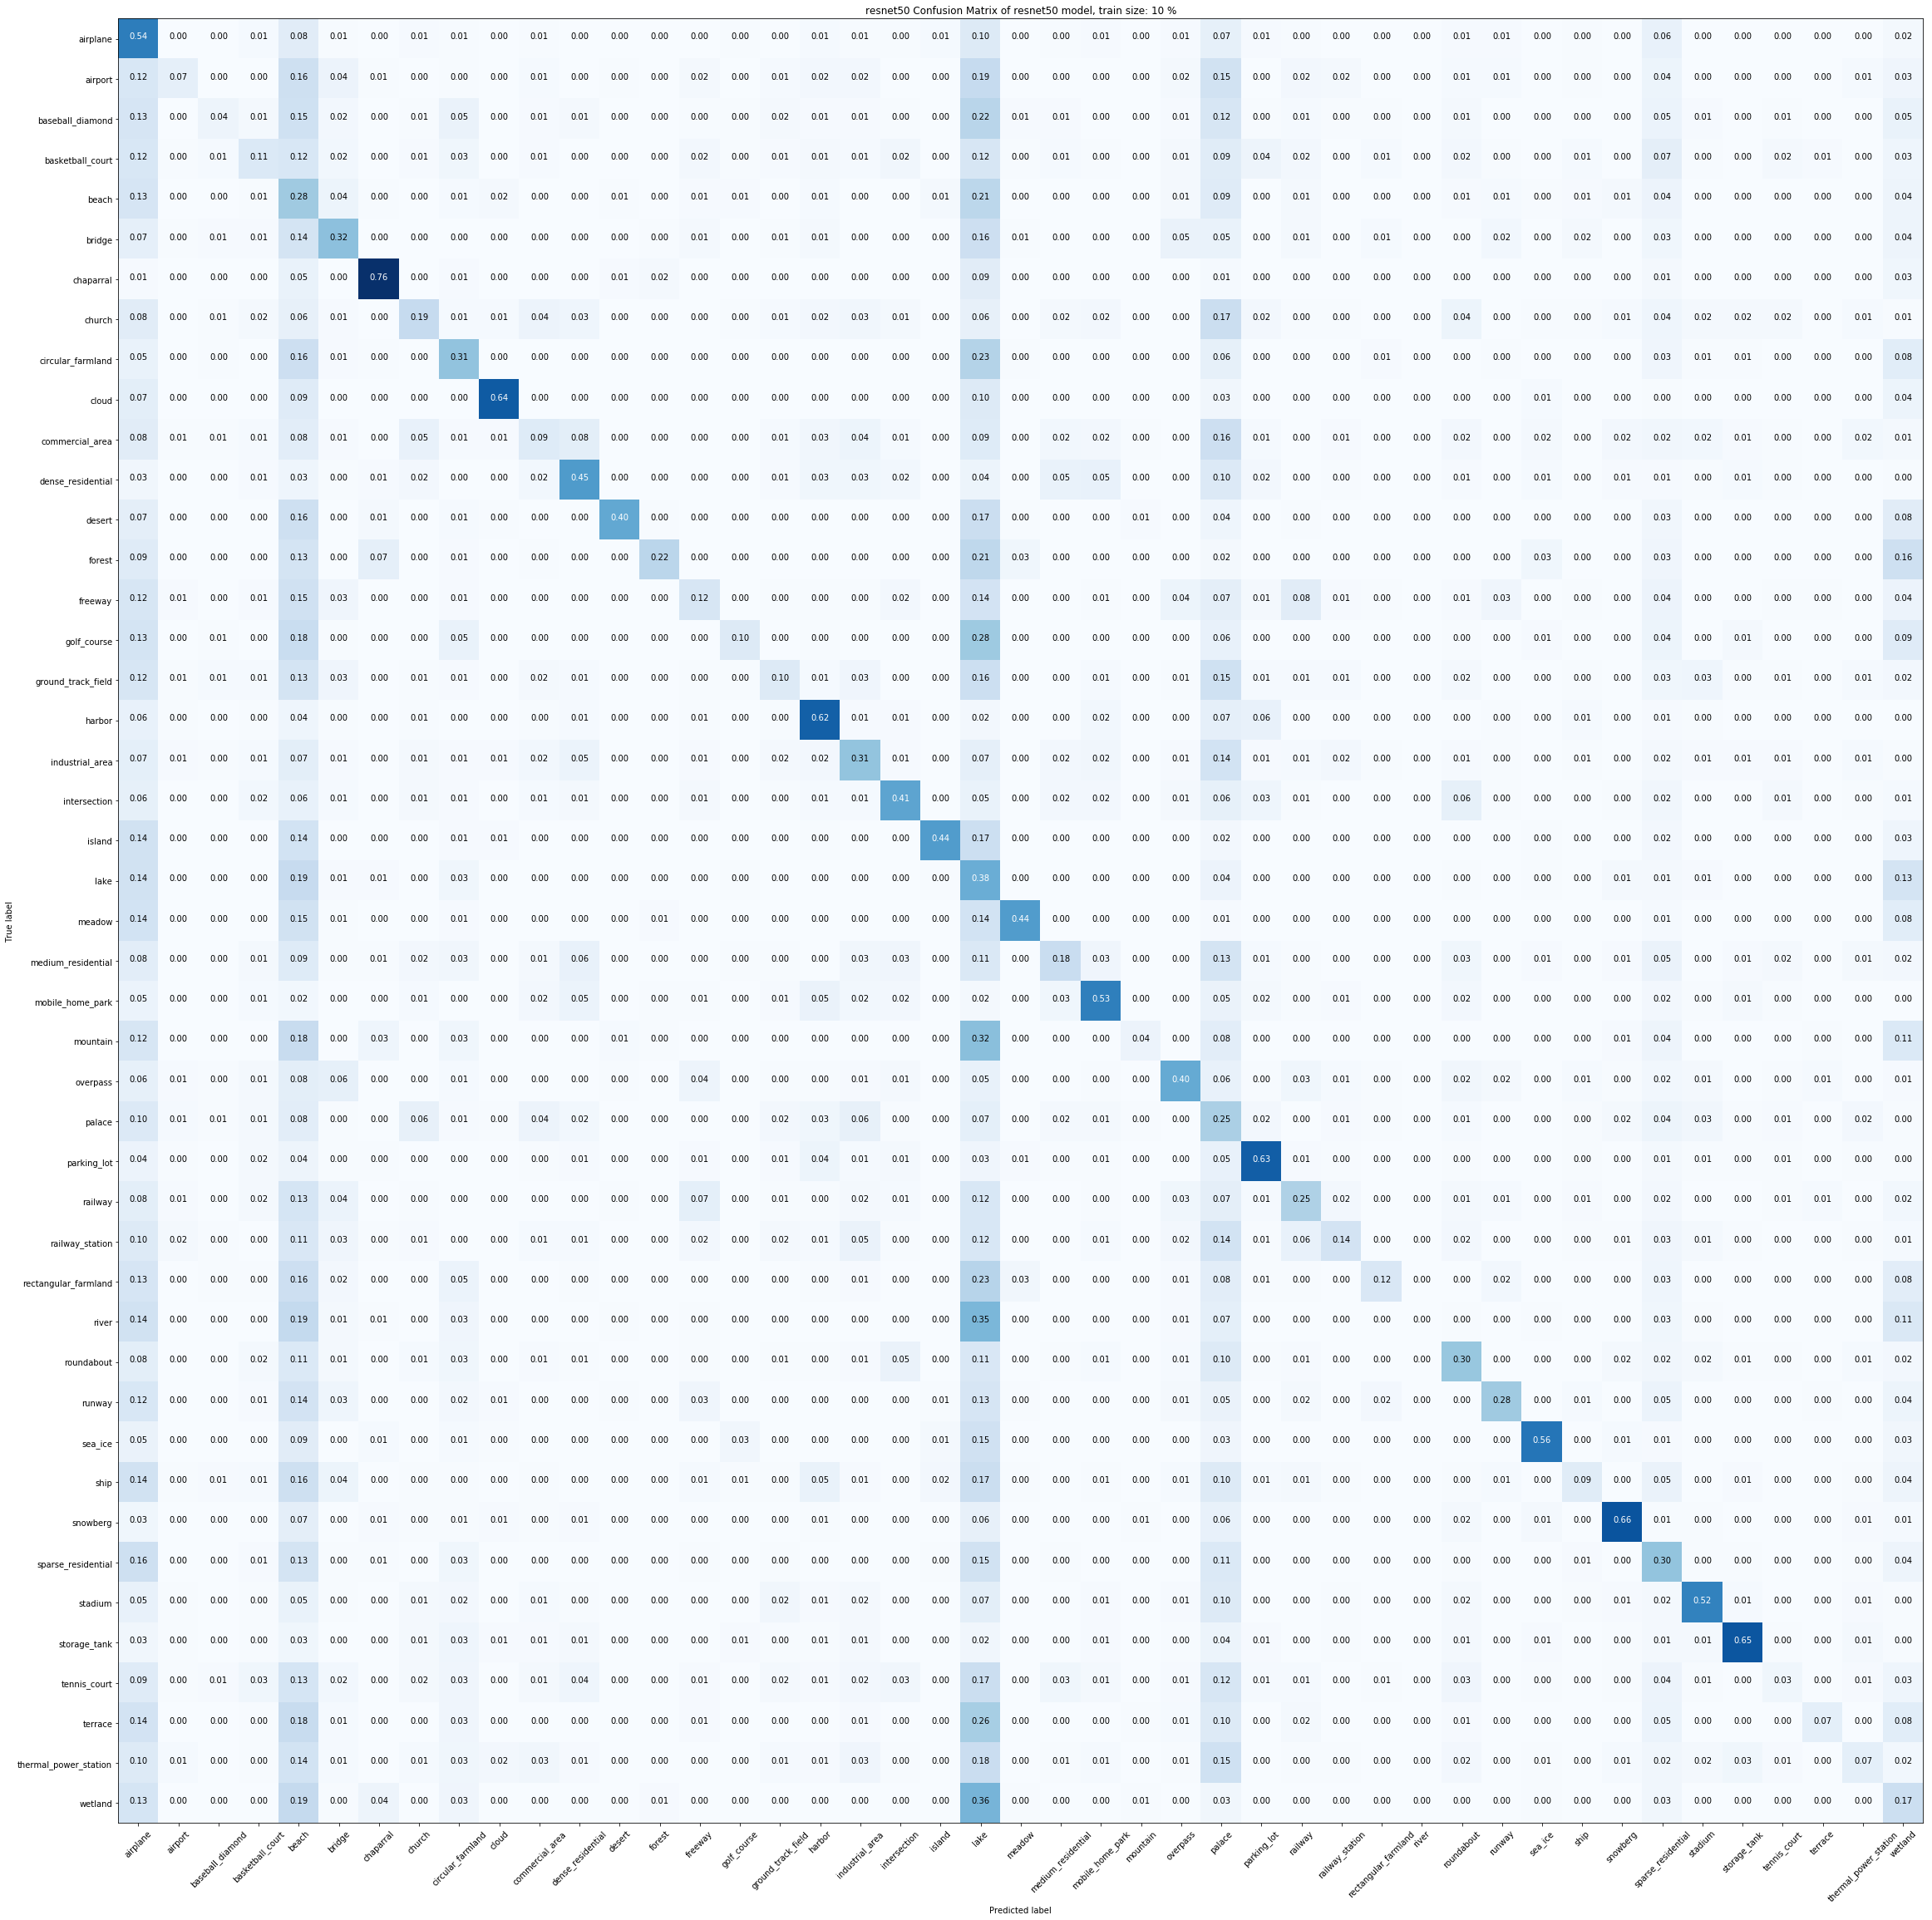

In [5]:
#plot the confusion matrix for train size of 20%

for key in confusion_matricies_1.keys():
    cmfn = np.sum(confusion_matricies_2[key], axis=0)
    
    visualize.plot_confusion_matrix(cmfn, classes, normalize=True, title=key\
                                    +' Confusion Matrix of '+key+' model, train size: 10 %')
    plt.show()

Normalized confusion matrix


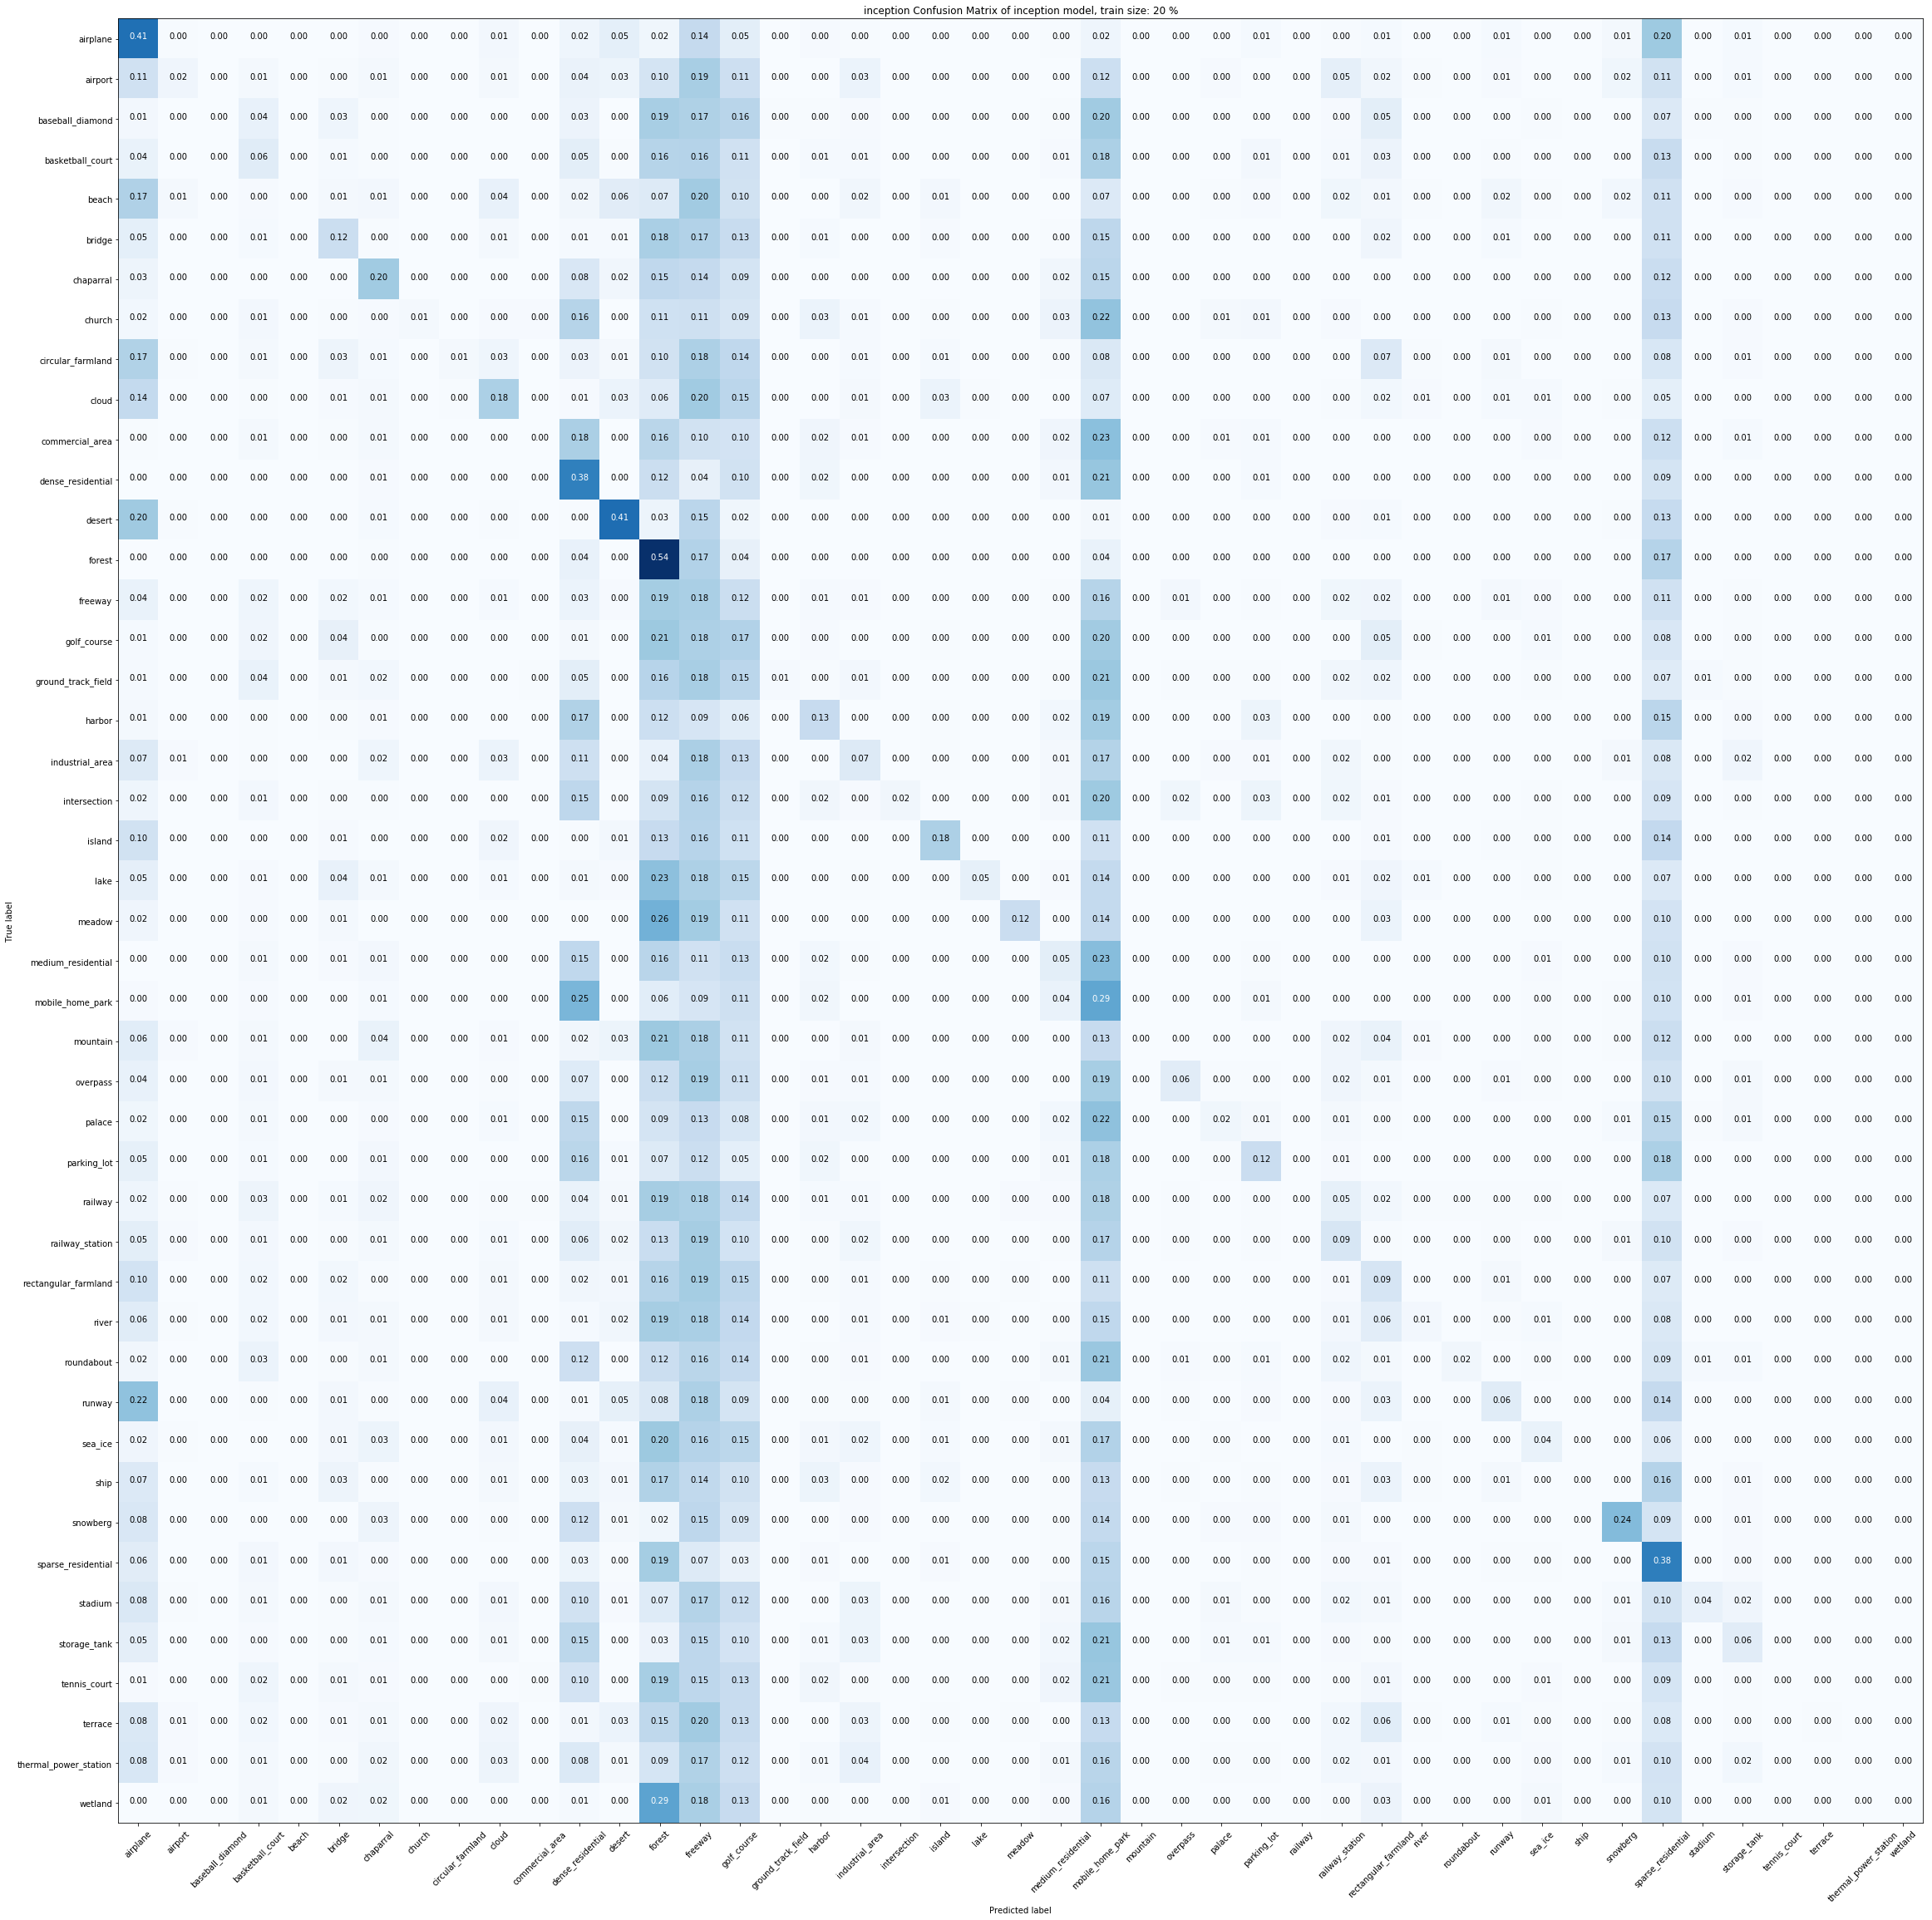

Normalized confusion matrix


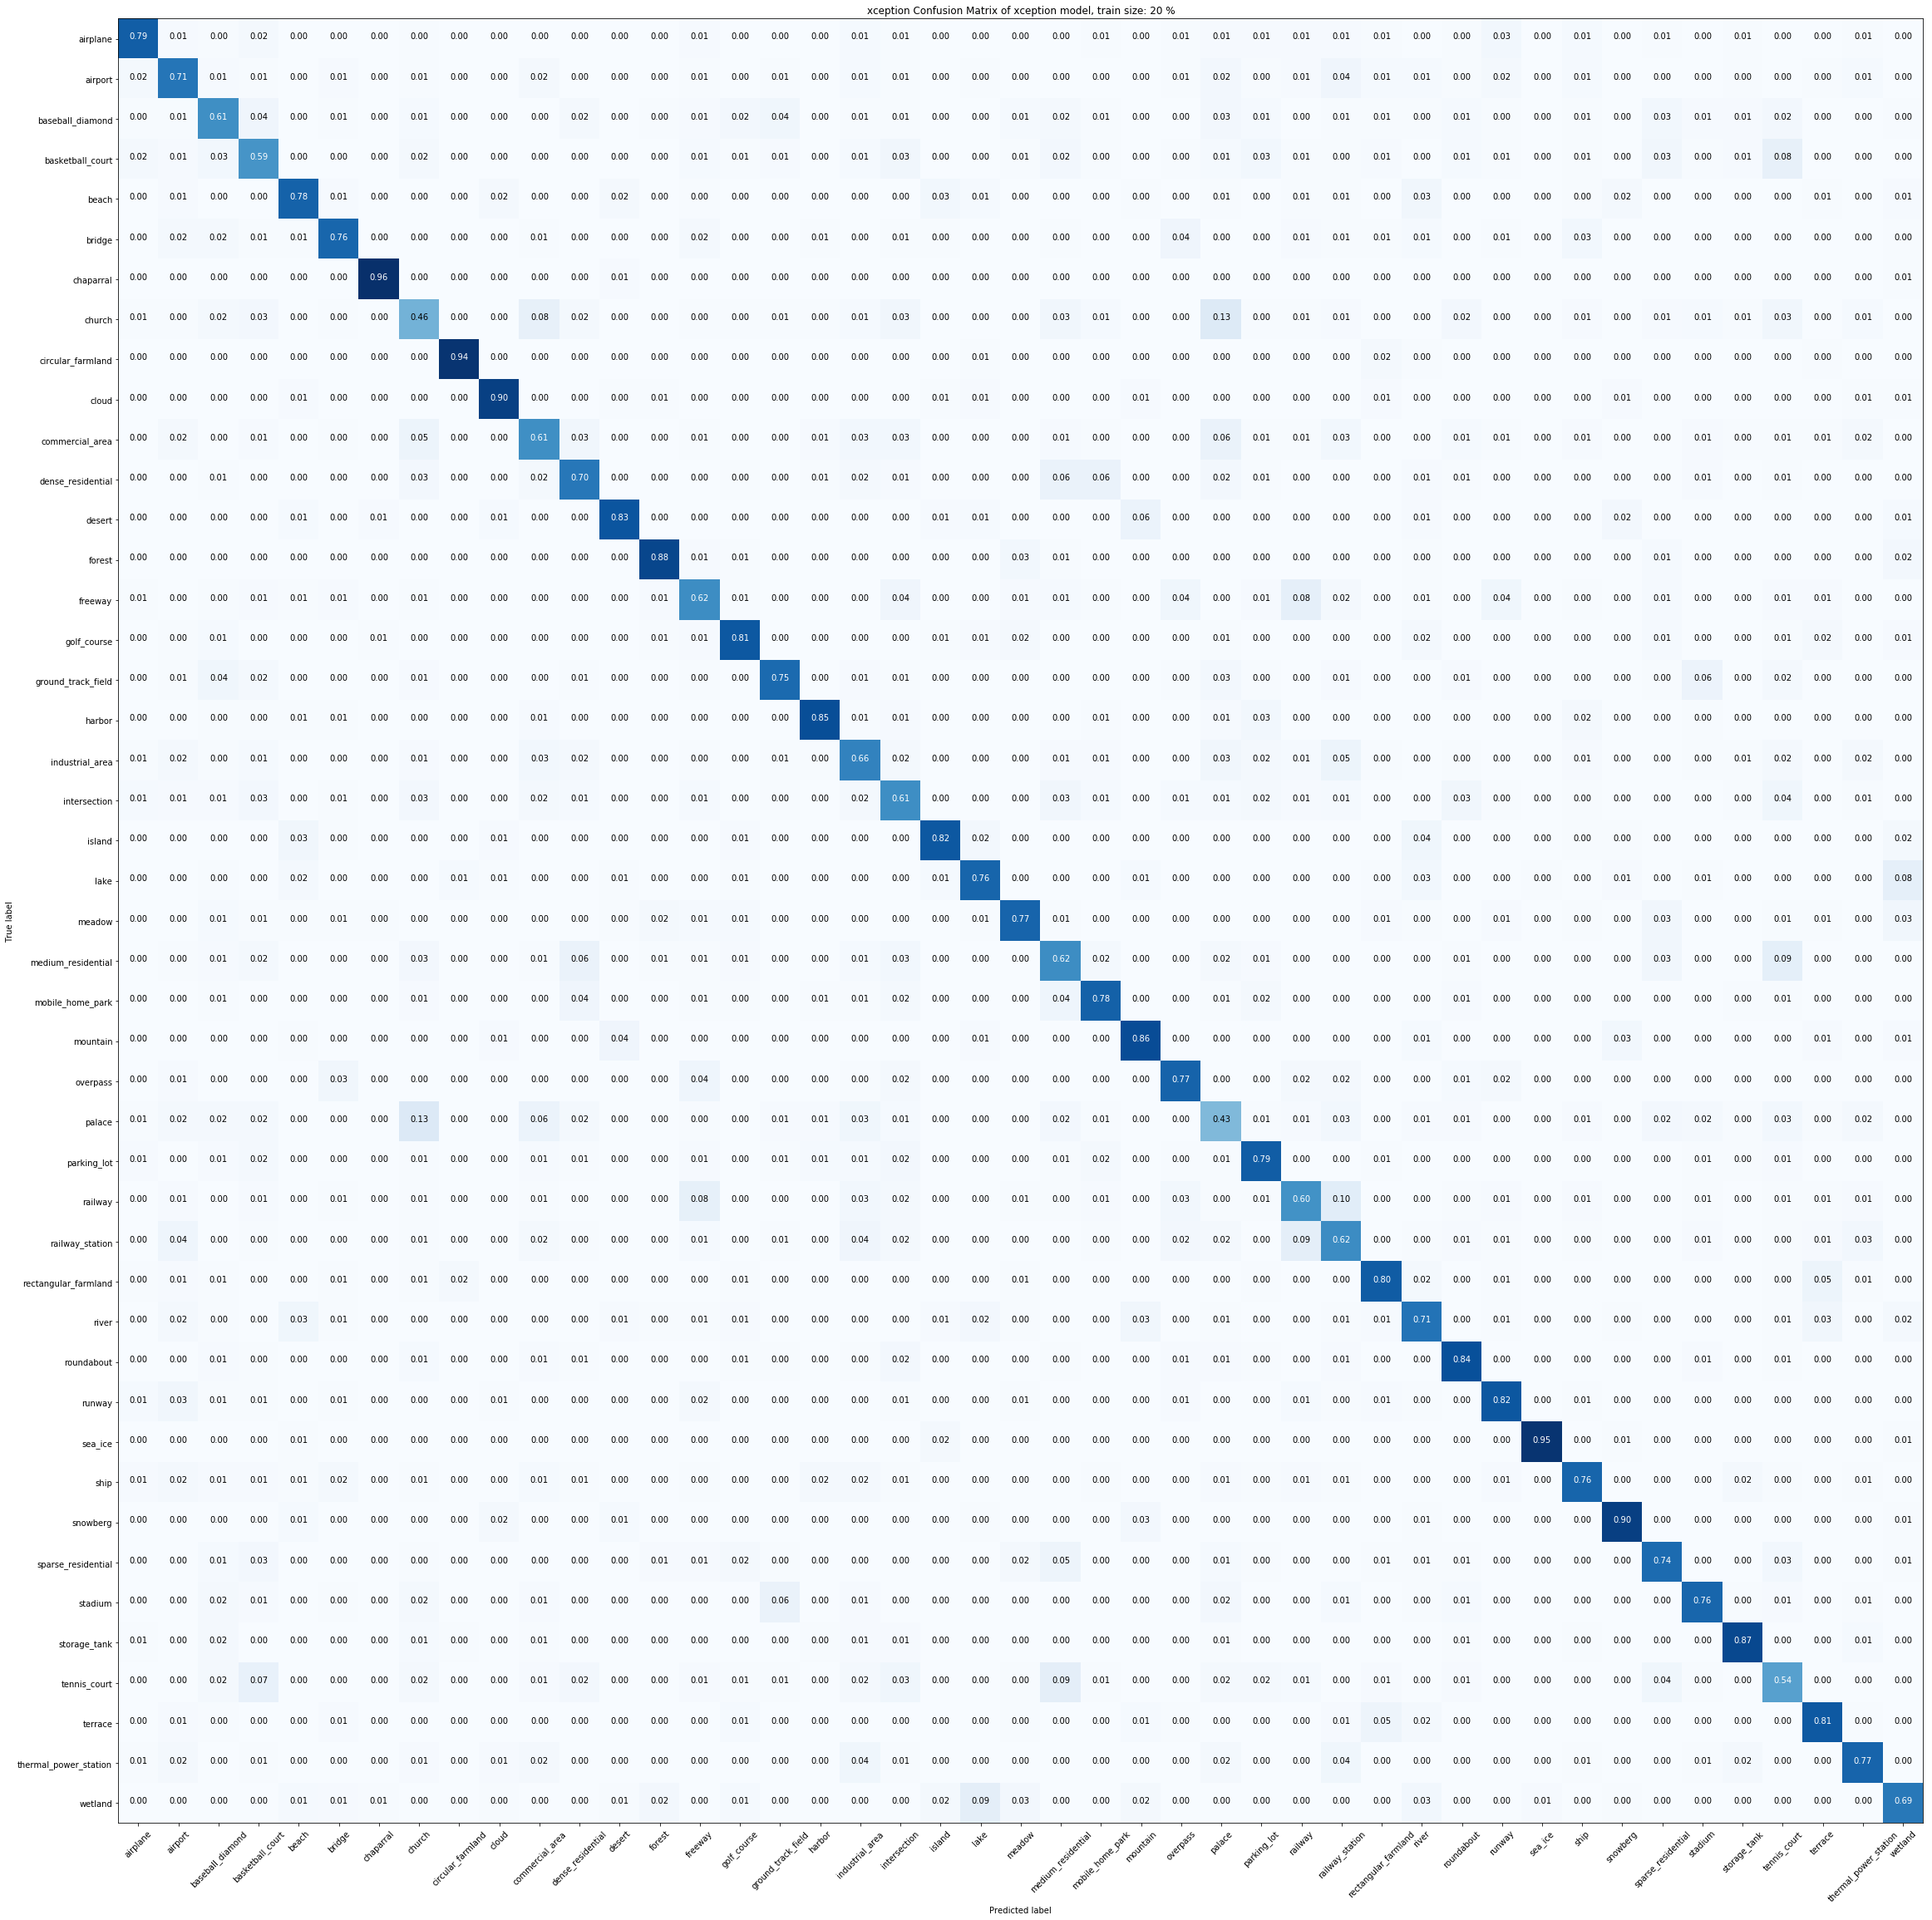

Normalized confusion matrix


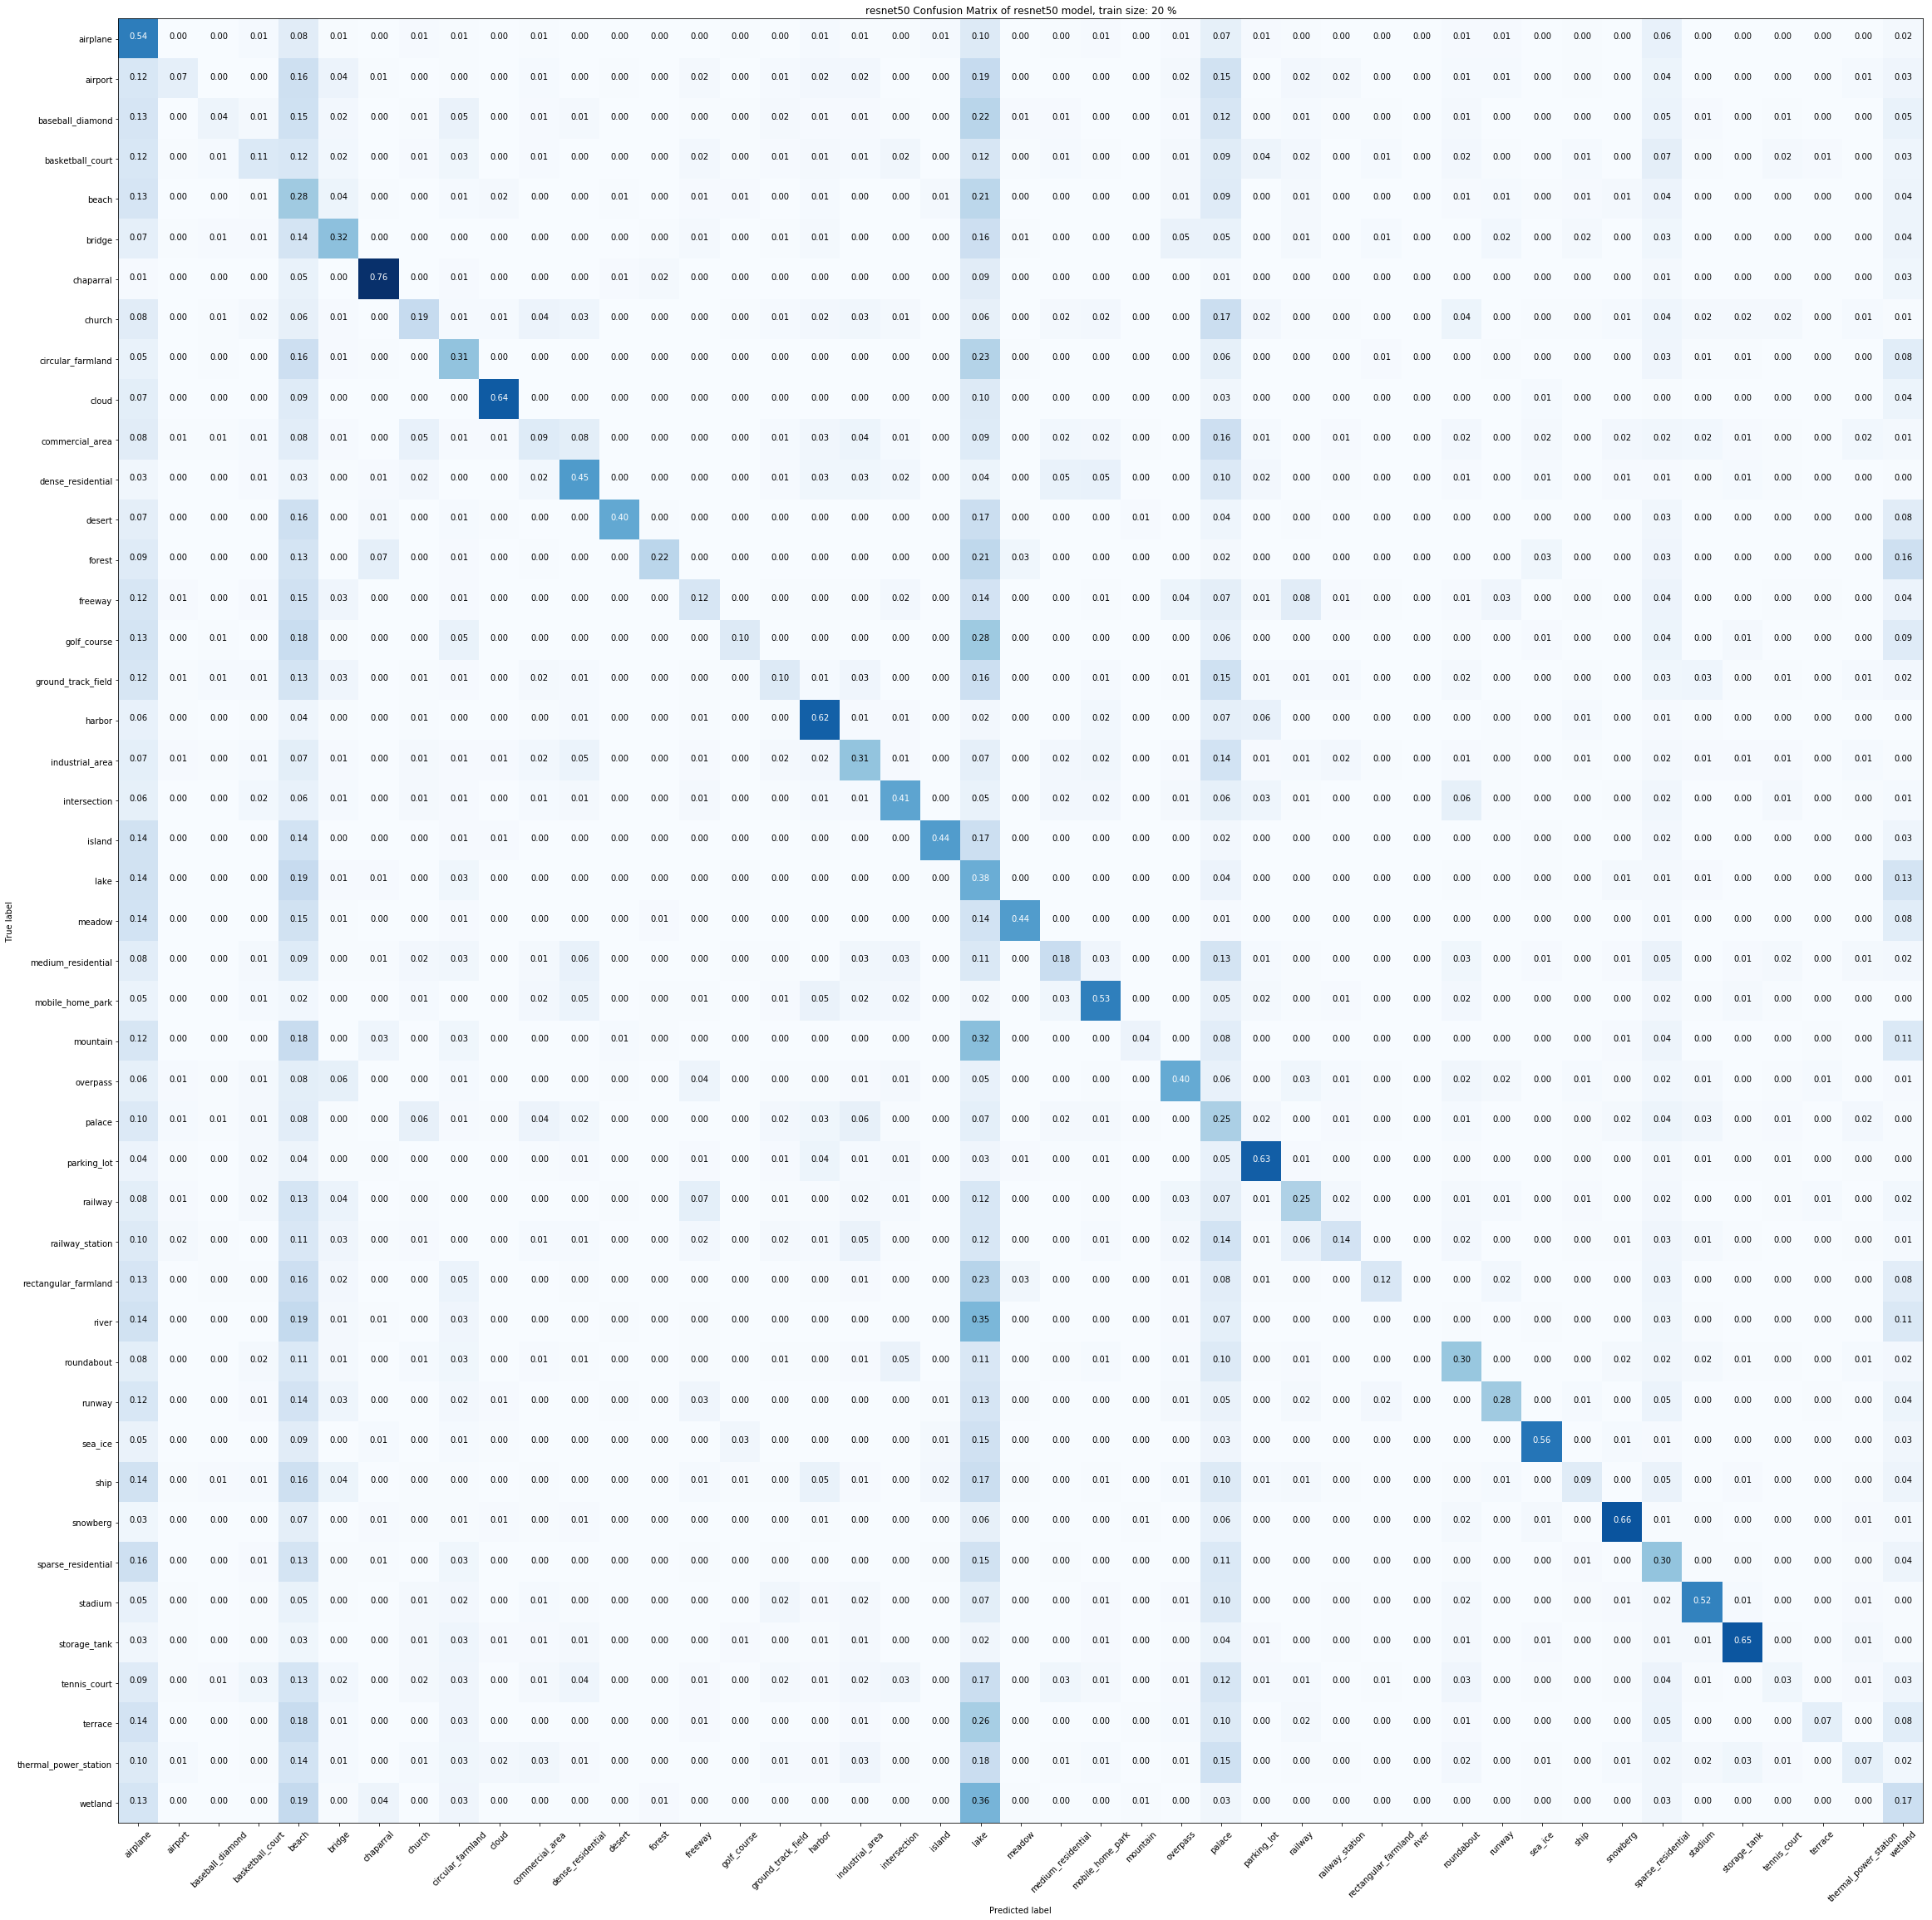

In [6]:
#plot the confusion matrix for train size of 20%
for key in confusion_matricies_2.keys():
    cmfn = np.sum(confusion_matricies_2[key], axis=0)
    
    visualize.plot_confusion_matrix(cmfn, classes, normalize=True, title=key\
                                    +' Confusion Matrix of '+key+' model, train size: 20 %')
    plt.show()